In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import json
from math import ceil
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

random_state = 42
score_types=["silhouette", "calinski_harabasz", "davies_bouldin"]

In [3]:
def df_cluster_scores(df_cluster : pd.DataFrame, initial_range : int, final_range : int, random:int=42, 
    score_types:list=["silhouette"], width_per_ax : int=5, height_per_ax : int=5): 
    
    km = KMeans(random_state=random)
    visualizer = KElbowVisualizer(km, k=(initial_range, final_range))
    visualizer.fit(df_cluster)
    visualizer.show()

    fitted_kmeans = {}
    labels_kmeans = {}
    df_scores = []
    for n_clusters in np.arange(initial_range, final_range):
        tmp_scores = {}
        tmp_scores["n_clusters"] = n_clusters
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=random)
        labels_clusters = kmeans.fit_predict(df_cluster)
        
        fitted_kmeans[n_clusters] = kmeans
        labels_kmeans[n_clusters] = labels_clusters
        
        if "silhouette" in score_types:
            silhouette = silhouette_score(df_cluster, labels_clusters)
            tmp_scores["silhouette"] = silhouette
        
        if "calinski_harabasz" in score_types:
            ch = calinski_harabasz_score(df_cluster, labels_clusters)
            tmp_scores["calinski_harabasz"] = ch
        
        if "davies_bouldin" in score_types:
            db = davies_bouldin_score(df_cluster, labels_clusters)
            tmp_scores["davies_bouldin"] = db
                    
        df_scores.append(tmp_scores)

    df_scores = pd.DataFrame(df_scores)
    df_scores.set_index("n_clusters", inplace=True)
    df_scores.plot(subplots=True, layout=(1,len(score_types)), figsize=(len(score_types) * width_per_ax, height_per_ax), xticks=np.arange(initial_range, final_range+1))

    return

In [4]:
def multi_visualize_silhoutte(df_cluster : pd.DataFrame, initial_range : int, final_range : int, 
        per_col : int=2, random : int=42, width_per_ax : int=6, height_per_ax : int=5):
    
    lines = ceil((final_range-initial_range)/per_col)
    
    fig, axes = plt.subplots(lines, per_col, figsize=(per_col*width_per_ax,lines*height_per_ax))
    for pos, nCluster in enumerate(range(initial_range, final_range)):
        km = KMeans(n_clusters=nCluster, random_state=random)
        
        if lines == 1:
            ax=axes[pos]
        else: 
            q, mod = divmod(pos, per_col)
            ax = axes[q][mod]
        
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax)
        visualizer.fit(df_cluster)
        ax.set_title(f"clusters = {nCluster}\nscore = {visualizer.silhouette_score_}") 

    return

In [5]:
def visualize_silhoutte(df_cluster : pd.DataFrame, n_cluster : int, random : int=42, width_per_ax : int=6, height_per_ax : int=5, versao_cluster : str="clusters"):
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(width_per_ax, height_per_ax)
    km = KMeans(n_clusters=n_cluster, random_state=random)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax1)
    visualizer.fit(df_cluster)
    ax1.set_title(f"{versao_cluster} = {n_cluster}\nscore = {visualizer.silhouette_score_}") 

    return 

In [6]:
df = pd.read_parquet(path="./../data/clean_data/category_seasonal_data.parquet")
df

comdate_diff   price  freight_value  days_since_year_start_commercial  \
0                  2  124.99          21.88                               133   
1                 11  289.00          46.48                                 0   
2                  6  139.94          17.79                               132   
3                  5  149.94          23.36                                66   
4                -14  230.00          22.25                               223   
...              ...     ...            ...                               ...   
115013             6   74.90          13.88                                90   
115014             3  114.90          14.16                                90   
115015             7   37.00          19.04                                90   
115016           -21  689.00          22.07                               327   
115017            -6   13.99           7.78                               358   

        days_since_month_start_commercial  year_commercial  month_commercial  \
0                                      13             2017                 5   
1                                       0             2018                 1   
2                                      12             2018                 5   
3                                       7             2018                 3   
4                                      11             2018                 8   
...                                   ...              ...               ...   
115013                                  0             2018                 4   
115014                                  0             2018                 4   
115015                                  0             2018                 4   
115016                                 23             2017                11   
115017                                 24             2017                12   

        day_of_month_commercial  day_of_week_commercial  \
0                            14                       6   
1                             1                       0   
2                            13                       6   
3                             8                       3   
4                            12                       6   
...                         ...                     ...   
115013                        1                       6   
115014                        1                       6   
115015                        1                       6   
115016                       24                       4   
115017                       25                       0   

        days_since_year_start_purchase  days_since_month_start_purchase  \
0                                  135                               15   
1                                   11                               11   
2                                  138                               18   
3                                   71                               12   
4                                  209                               28   
...                                ...                              ...   
115013                              96                                6   
115014                              93                                3   
115015                              97                                7   
115016                             306                                2   
115017                             352                               18   

        year_purchase  month_purchase  day_of_month_purchase  \
0                2017               5                     16   
1                2018               1                     12   
2                2018               5                     19   
3                2018               3                     13   
4                2018               7                     29   
...               ...             ...                    ...   
115013          

In [7]:
df_clean = df.copy()
df_clean.drop(columns=["day_of_month_commercial", "day_of_month_purchase", "year_commercial"], inplace=True)
df_clean

comdate_diff   price  freight_value  days_since_year_start_commercial  \
0                  2  124.99          21.88                               133   
1                 11  289.00          46.48                                 0   
2                  6  139.94          17.79                               132   
3                  5  149.94          23.36                                66   
4                -14  230.00          22.25                               223   
...              ...     ...            ...                               ...   
115013             6   74.90          13.88                                90   
115014             3  114.90          14.16                                90   
115015             7   37.00          19.04                                90   
115016           -21  689.00          22.07                               327   
115017            -6   13.99           7.78                               358   

        days_since_month_start_commercial  month_commercial  \
0                                      13                 5   
1                                       0                 1   
2                                      12                 5   
3                                       7                 3   
4                                      11                 8   
...                                   ...               ...   
115013                                  0                 4   
115014                                  0                 4   
115015                                  0                 4   
115016                                 23                11   
115017                                 24                12   

        day_of_week_commercial  days_since_year_start_purchase  \
0                            6                             135   
1                            0                              11   
2                            6                             138   
3                            3                              71   
4                            6                             209   
...                        ...                             ...   
115013                       6                              96   
115014                       6                              93   
115015                       6                              97   
115016                       4                             306   
115017                       0                             352   

        days_since_month_start_purchase  year_purchase  month_purchase  \
0                                    15           2017               5   
1                                    11           2018               1   
2                                    18           2018               5   
3                                    12           2018               3   
4                                    28           2018               7   
...                                 ...            ...             ...   
115013                                6           2018               4   
115014                                3           2018               4   
115015                                7           2018               4   
115016                                2           2017              11   
115017                               18           2017              12   

        day_of_week_purchase  commercial_date_coded  time_window_order_coded  \
0                          1                      3                        1   
1                          4                      7                        1   
2                          5                      3                        1   
3                          1                      1                        1   
4                          6                      5                        0   
...                      ...                    ...                      ...   
115013                     5        

In [8]:
encoders = {}
with open("./../data/clean_data/labels_encoders.json", "r") as f:
    encoders = json.load(f)

categorias = encoders["filtered_category_coded"]
codigoOutros = int(list(categorias.keys())[list(categorias.values()).index("outros")])

df_clean = df_clean[df_clean["filtered_category_coded"] != codigoOutros]
df_clean

comdate_diff   price  freight_value  days_since_year_start_commercial  \
1                 11  289.00          46.48                                 0   
5                -28  259.90          22.31                               284   
6                -17   14.99           7.78                                66   
8                 17   25.00          14.10                                 0   
9                  7   99.90          22.57                                 0   
...              ...     ...            ...                               ...   
115012            -8   55.00          20.88                               358   
115014             3  114.90          14.16                                90   
115015             7   37.00          19.04                                90   
115016           -21  689.00          22.07                               327   
115017            -6   13.99           7.78                               358   

        days_since_month_start_commercial  month_commercial  \
1                                       0                 1   
5                                      11                10   
6                                       7                 3   
8                                       0                 1   
9                                       0                 1   
...                                   ...               ...   
115012                                 24                12   
115014                                  0                 4   
115015                                  0                 4   
115016                                 23                11   
115017                                 24                12   

        day_of_week_commercial  days_since_year_start_purchase  \
1                            0                              11   
5                            3                             256   
6                            3                              49   
8                            0                              17   
9                            0                               7   
...                        ...                             ...   
115012                       0                             350   
115014                       6                              93   
115015                       6                              97   
115016                       4                             306   
115017                       0                             352   

        days_since_month_start_purchase  year_purchase  month_purchase  \
1                                    11           2018               1   
5                                    13           2017               9   
6                                    18           2018               2   
8                                    17           2018               1   
9                                     7           2018               1   
...                                 ...            ...             ...   
115012                               16           2017              12   
115014                                3           2018               4   
115015                                7           2018               4   
115016                                2           2017              11   
115017                               18           2017              12   

        day_of_week_purchase  commercial_date_coded  time_window_order_coded  \
1                          4                      7                        1   
5                          3                      7                        1   
6                          0                      1                        0   
8                          3                      7                        1   
9                          0                      9                        1   
...                      ...                    ...                      ...   
115012                     6        

In [8]:
init_range = 2
end_range = 13 

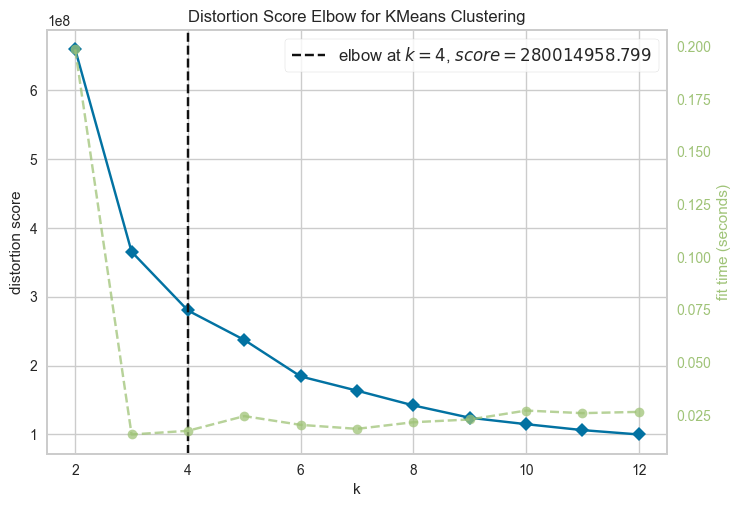

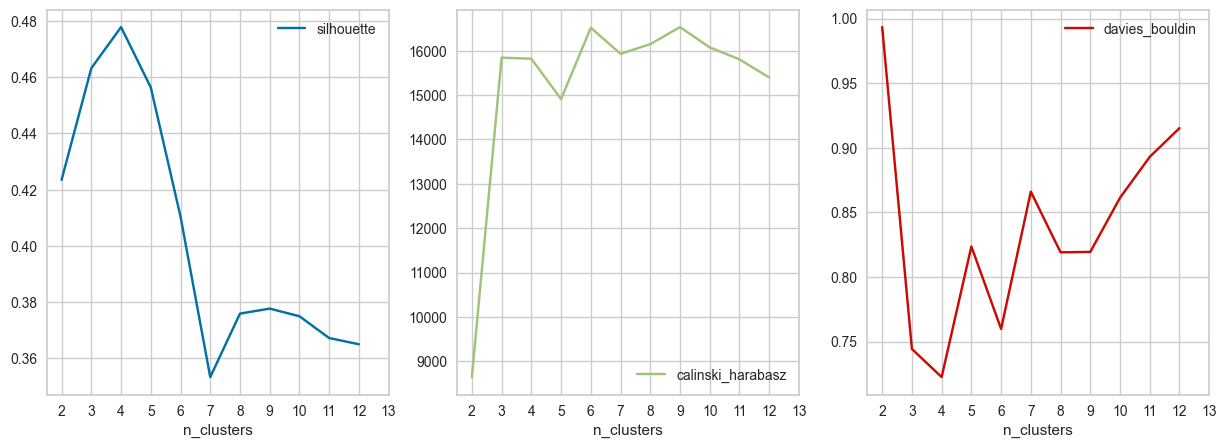

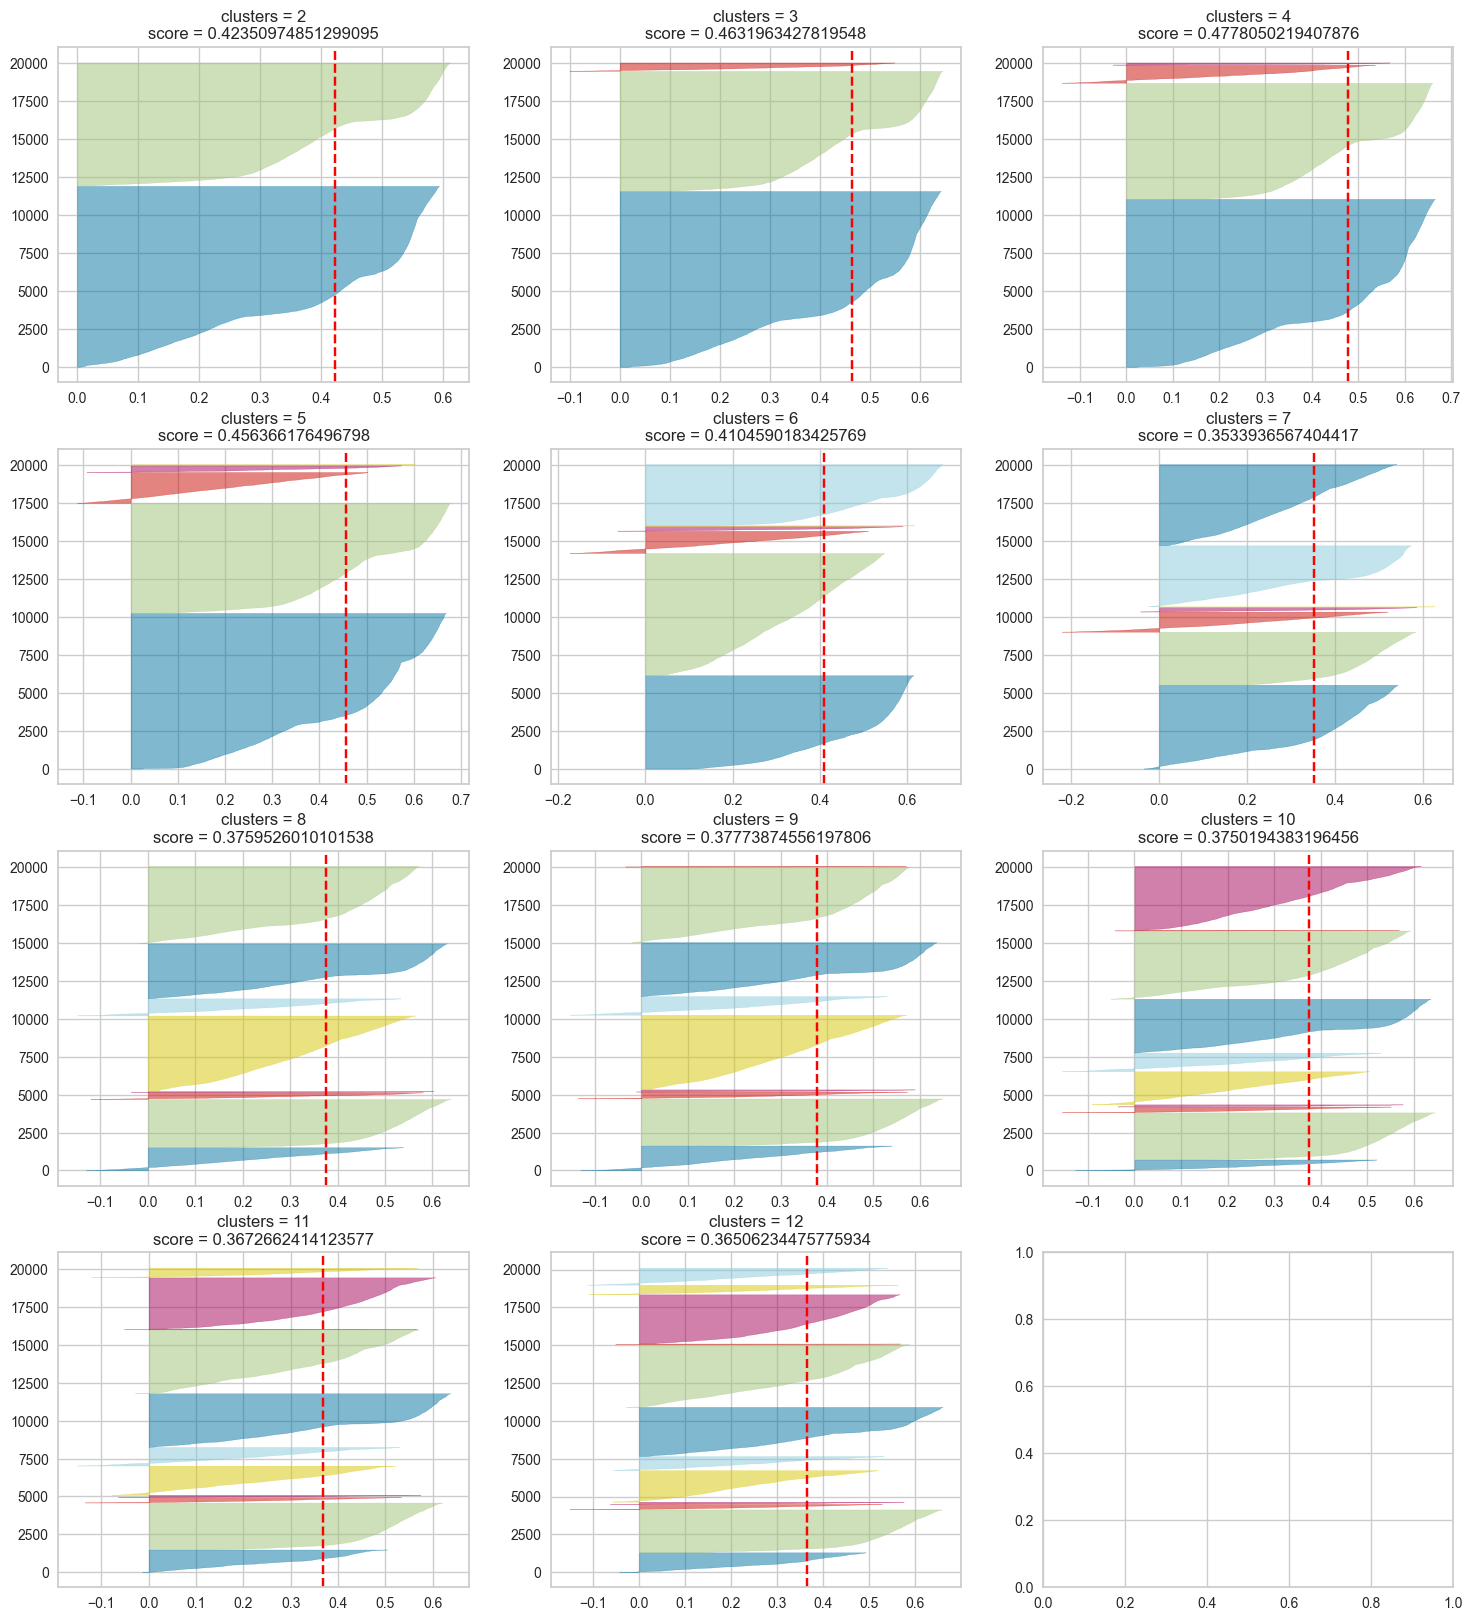

In [9]:
df_sample_20_clean = df_clean.sample(n=20000, random_state=42)
df_cluster_scores(df_sample_20_clean, initial_range=init_range, final_range=end_range, score_types=score_types)
multi_visualize_silhoutte(df_sample_20_clean, initial_range=init_range, final_range=end_range, per_col=3)

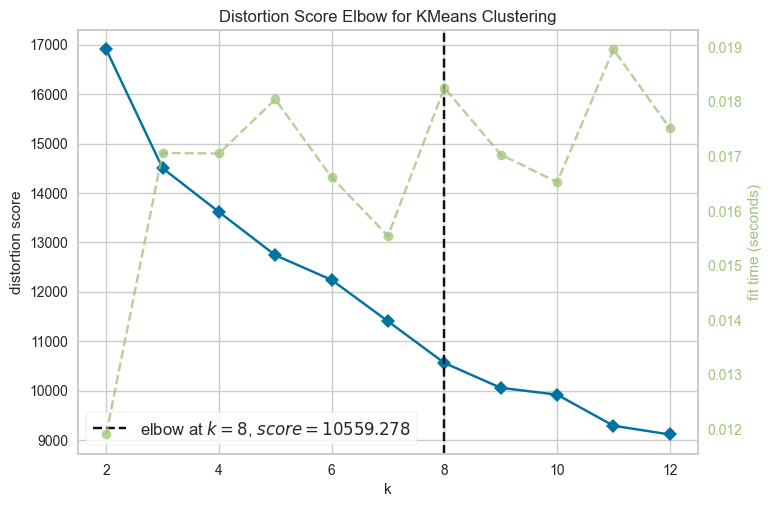

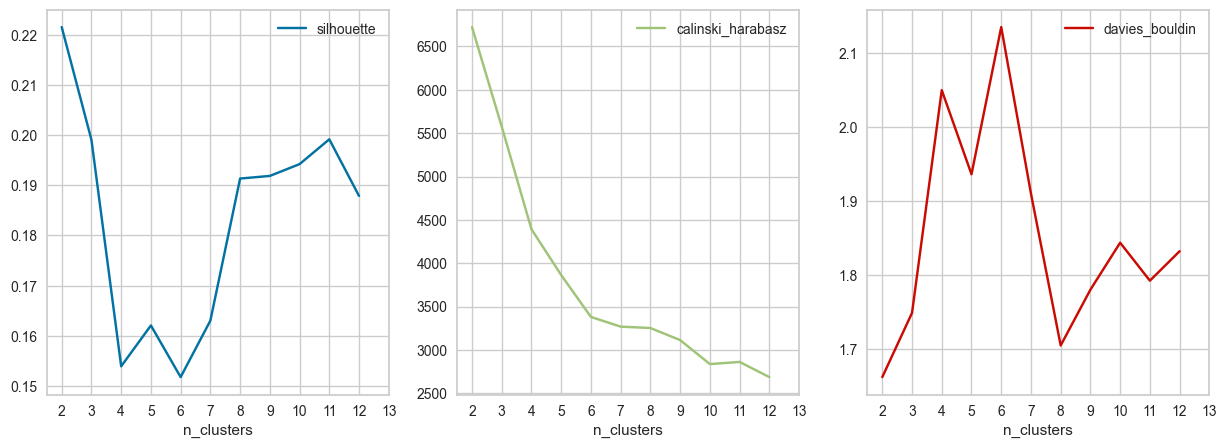

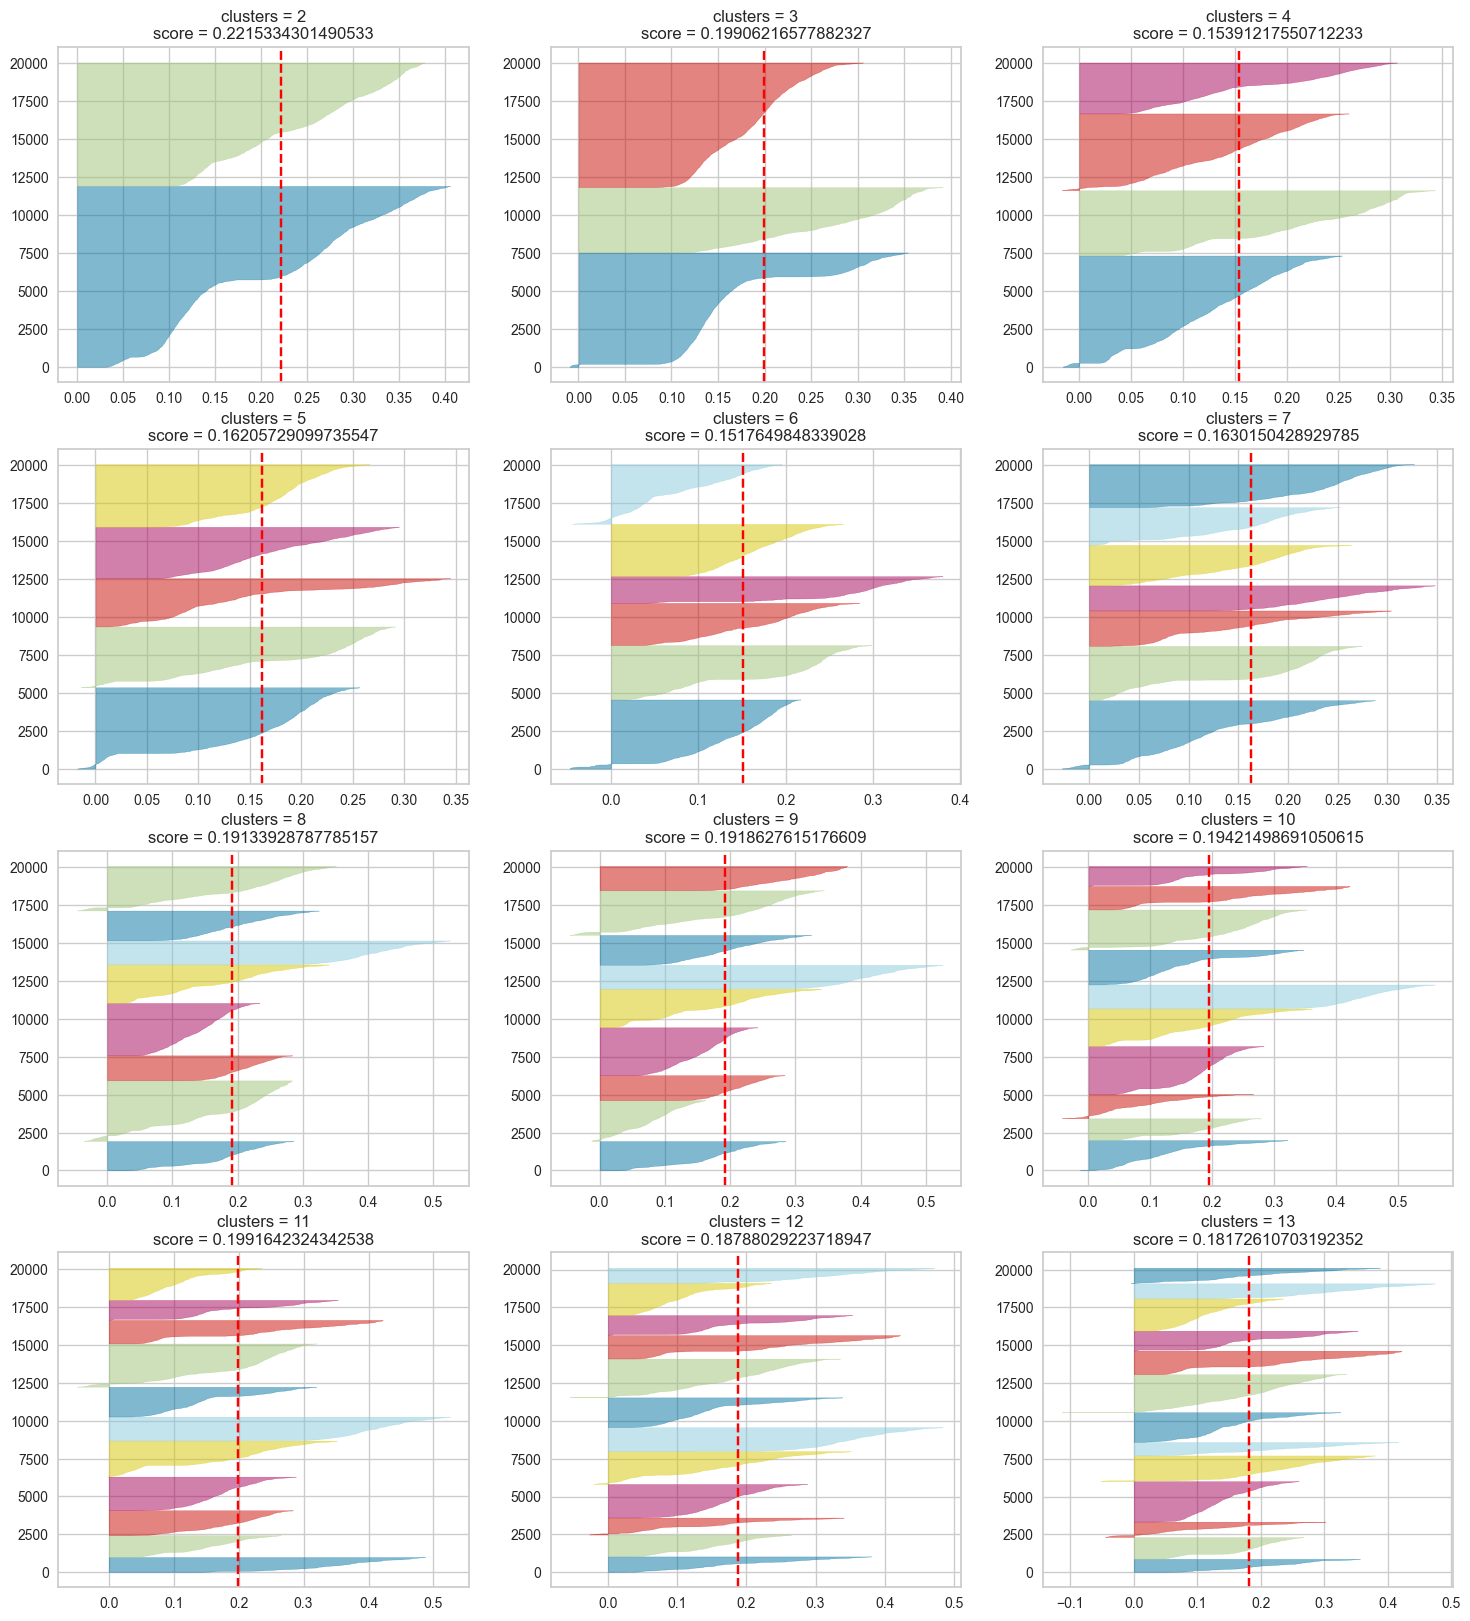

In [10]:
normalizer = MinMaxScaler()
df_sample_20_clean_normalized = normalizer.fit_transform(df_sample_20_clean)
df_cluster_scores(df_sample_20_clean_normalized, initial_range=init_range, final_range=end_range, score_types=score_types)
multi_visualize_silhoutte(df_sample_20_clean_normalized, 2, 14, per_col=3)

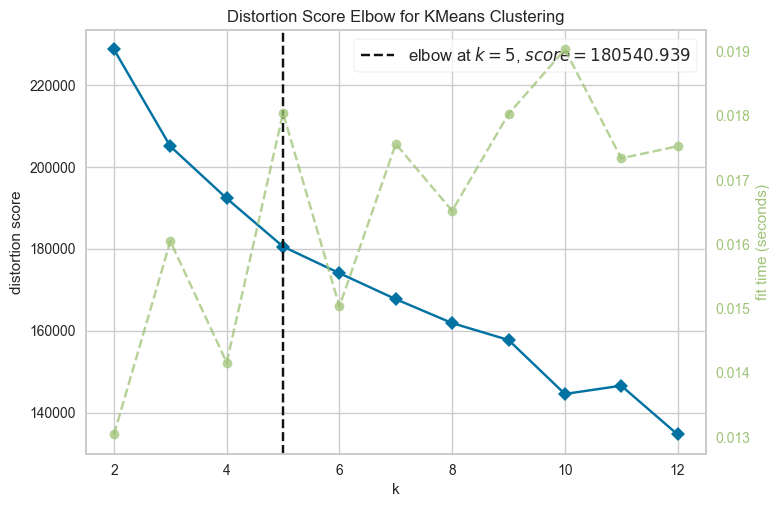

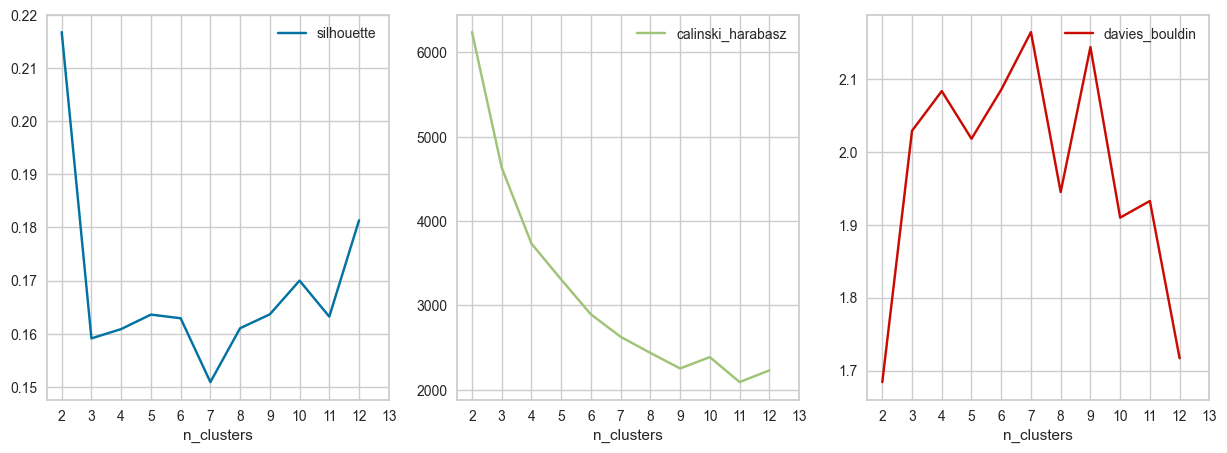

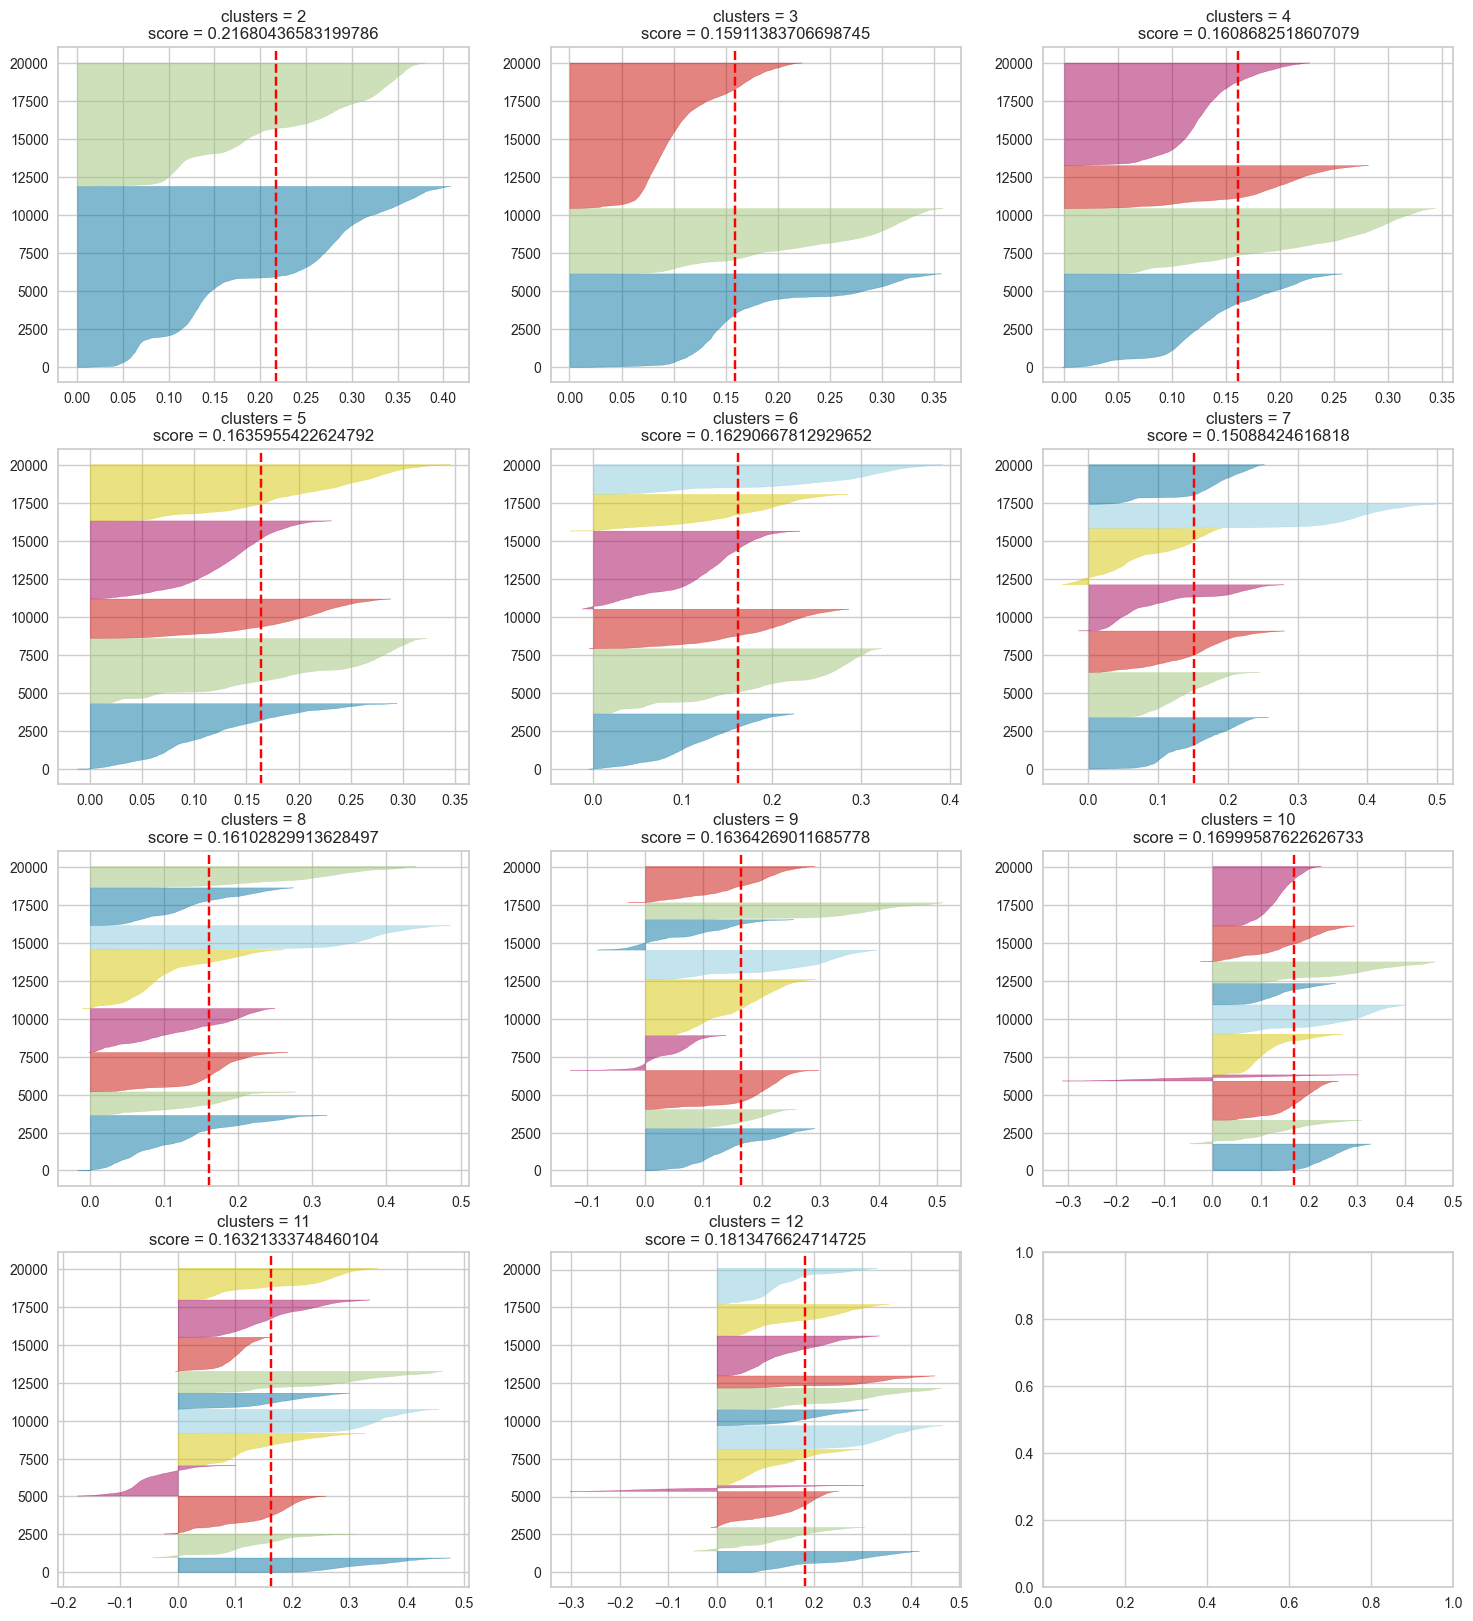

In [11]:
scaler = StandardScaler()
df_sample_20_clean_standardized = scaler.fit_transform(df_sample_20_clean)
df_cluster_scores(df_sample_20_clean_standardized, initial_range=init_range, final_range=end_range, score_types=score_types)
multi_visualize_silhoutte(df_sample_20_clean_standardized, initial_range=init_range, final_range=end_range, per_col=3)

In [11]:
scaler = StandardScaler()
nparray_clean_standardized = scaler.fit_transform(df_clean)

df_clean_standardized = pd.DataFrame({f'{df_clean.columns[i]}': nparray_clean_standardized[:,i] for i in range(nparray_clean_standardized.shape[1])})
df_clean_standardized

n_clusters = 2
kmeans_model = KMeans(n_clusters, random_state=42)
clusters = kmeans_model.fit_predict(df_clean_standardized)
df_kmeans = pd.DataFrame(df_clean_standardized)

cluster_clean_std_kmeans = df_clean.copy()
cluster_clean_std_kmeans["cluster"] = kmeans_model.labels_
cluster_clean_std_kmeans["hue"] = cluster_clean_std_kmeans["cluster"].map({0:"Cluster 1", 1:"Cluster 2", 2:"Cluster 3", 3:"Cluster 4"})
cluster_clean_std_kmeans

comdate_diff   price  freight_value  days_since_year_start_commercial  \
1                 11  289.00          46.48                                 0   
5                -28  259.90          22.31                               284   
6                -17   14.99           7.78                                66   
8                 17   25.00          14.10                                 0   
9                  7   99.90          22.57                                 0   
...              ...     ...            ...                               ...   
115012            -8   55.00          20.88                               358   
115014             3  114.90          14.16                                90   
115015             7   37.00          19.04                                90   
115016           -21  689.00          22.07                               327   
115017            -6   13.99           7.78                               358   

        days_since_month_start_commercial  month_commercial  \
1                                       0                 1   
5                                      11                10   
6                                       7                 3   
8                                       0                 1   
9                                       0                 1   
...                                   ...               ...   
115012                                 24                12   
115014                                  0                 4   
115015                                  0                 4   
115016                                 23                11   
115017                                 24                12   

        day_of_week_commercial  days_since_year_start_purchase  \
1                            0                              11   
5                            3                             256   
6                            3                              49   
8                            0                              17   
9                            0                               7   
...                        ...                             ...   
115012                       0                             350   
115014                       6                              93   
115015                       6                              97   
115016                       4                             306   
115017                       0                             352   

        days_since_month_start_purchase  year_purchase  month_purchase  \
1                                    11           2018               1   
5                                    13           2017               9   
6                                    18           2018               2   
8                                    17           2018               1   
9                                     7           2018               1   
...                                 ...            ...             ...   
115012                               16           2017              12   
115014                                3           2018               4   
115015                                7           2018               4   
115016                                2           2017              11   
115017                               18           2017              12   

        day_of_week_purchase  commercial_date_coded  time_window_order_coded  \
1                          4                      7                        1   
5                          3                      7                        1   
6                          0                      1                        0   
8                          3                      7                        1   
9                          0                      9                        1   
...                      ...                    ...                      ...   
115012                     6        

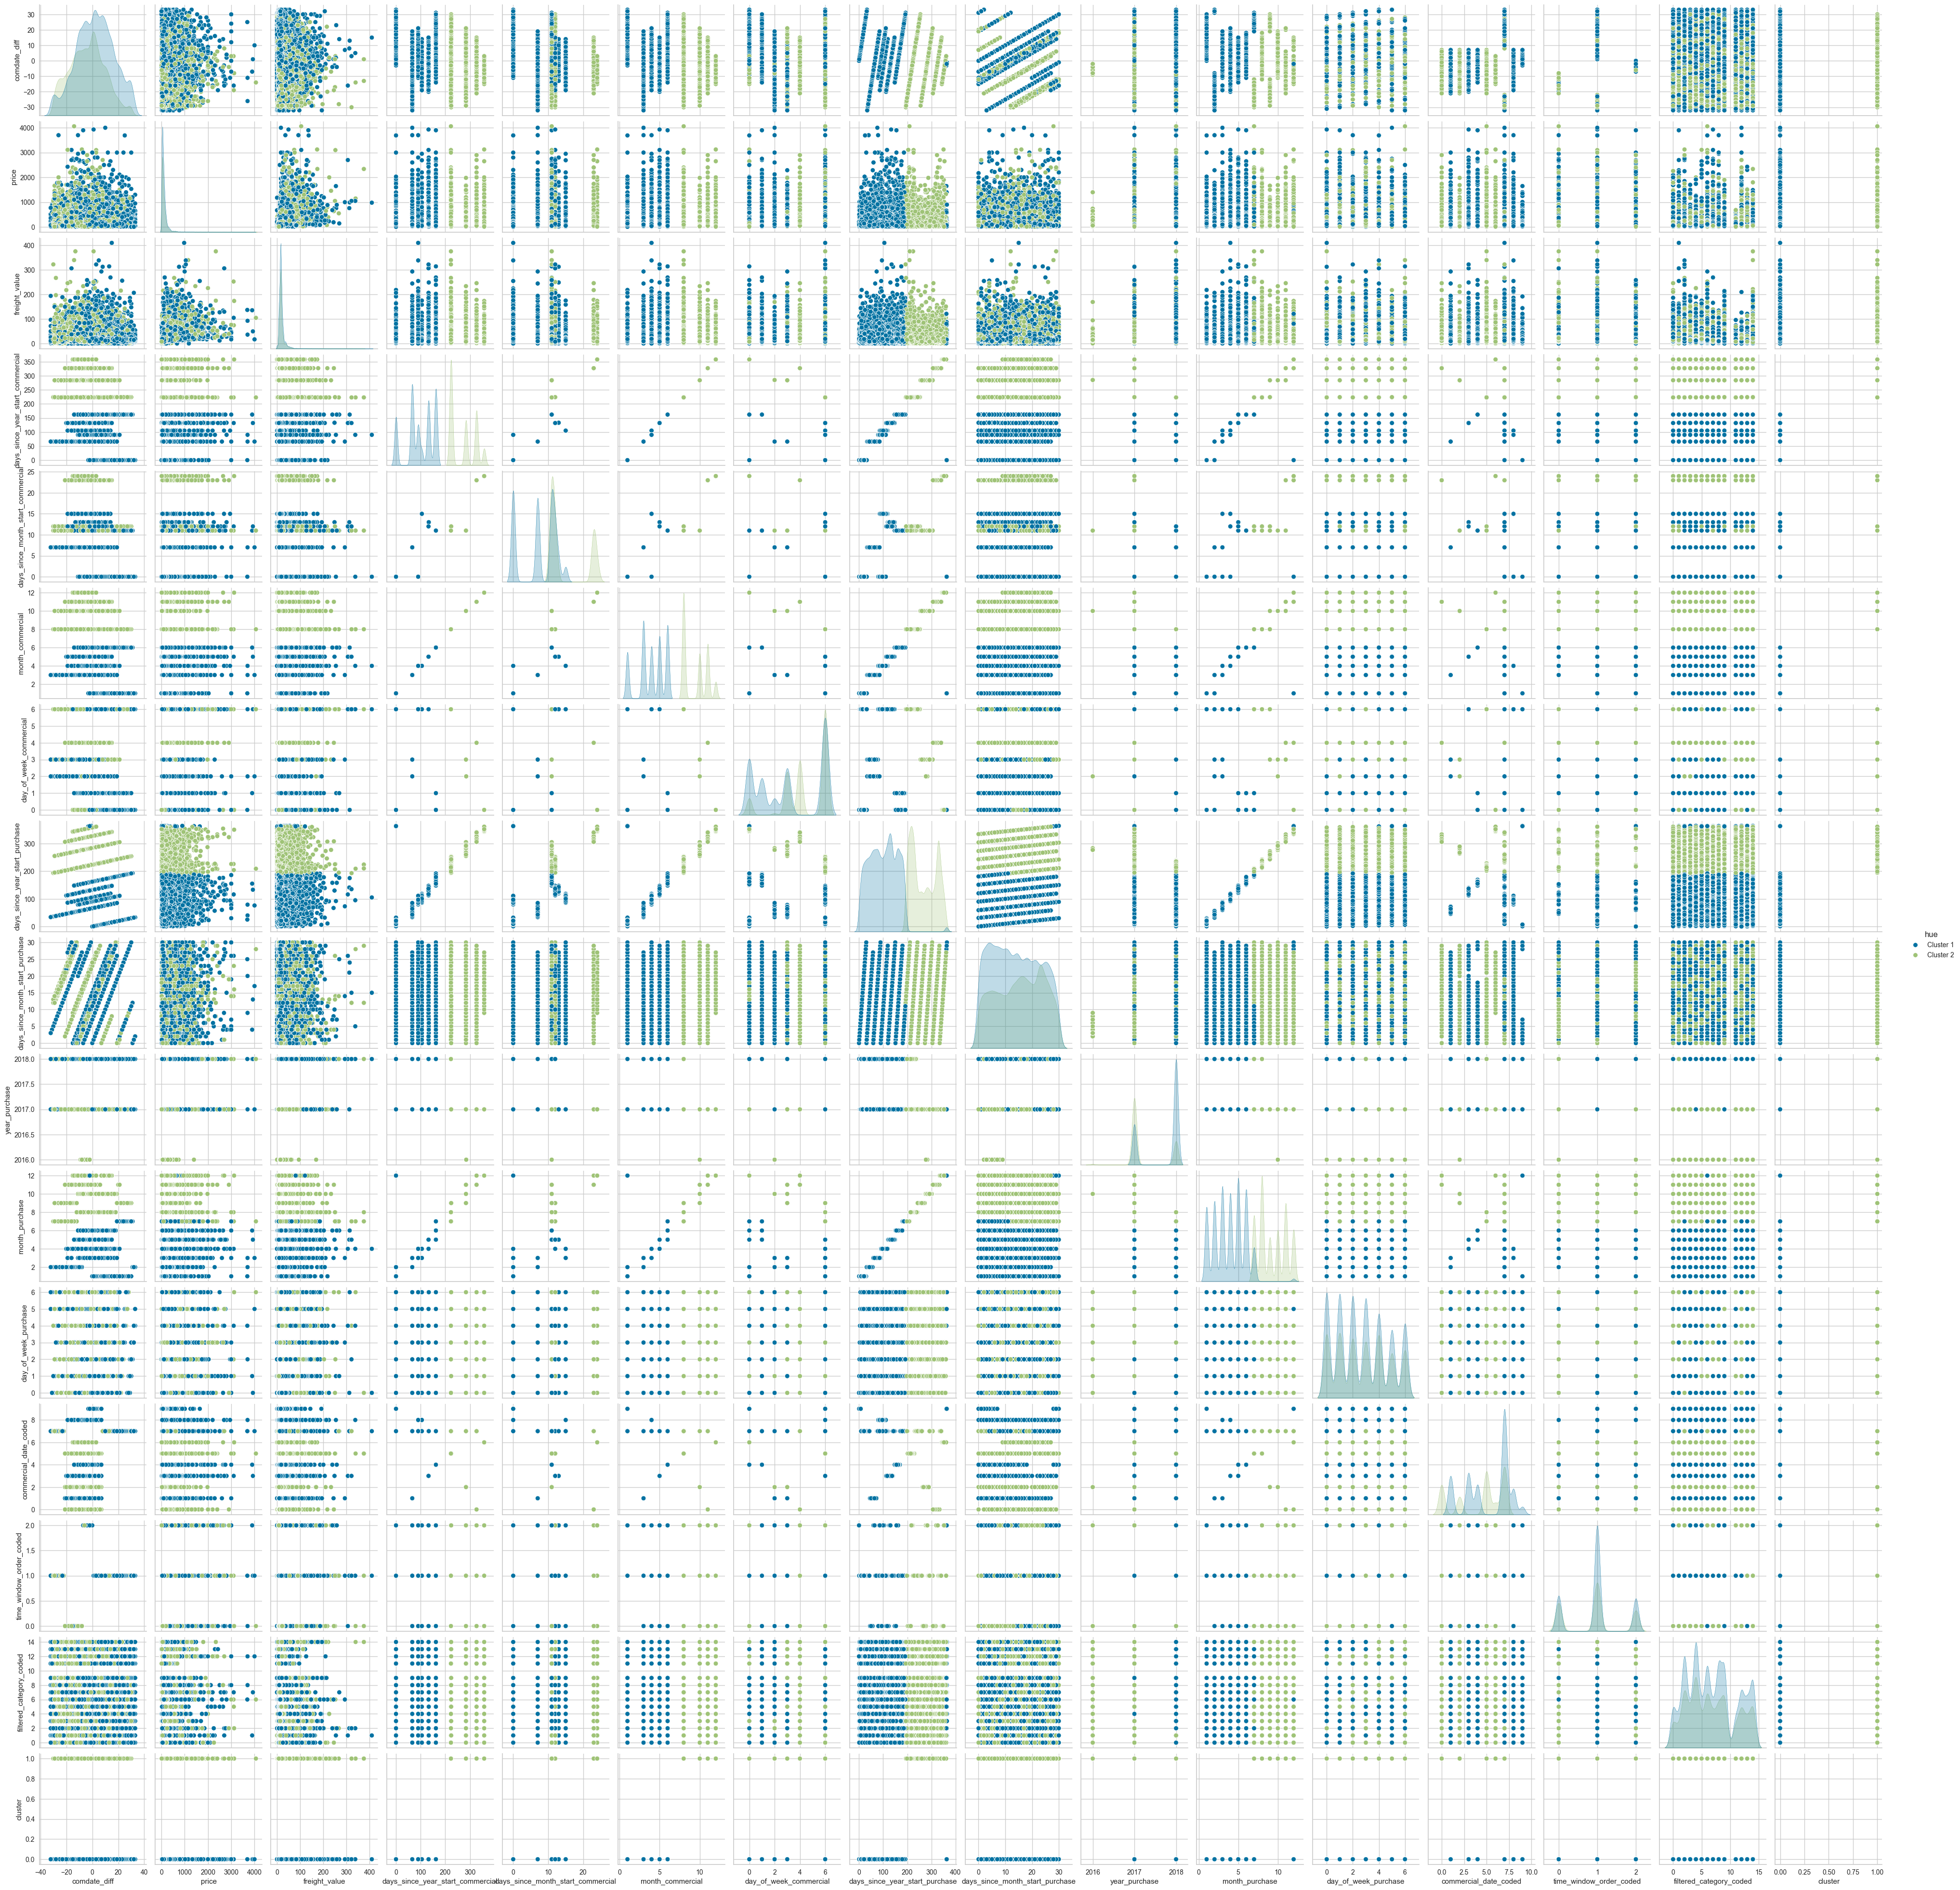

In [12]:
sns.pairplot(cluster_clean_std_kmeans[0:], hue="hue")